In [2]:
import pandas as pd #
import sys
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import math #
from sklearn import preprocessing #
from statistics import mean, stdev

import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import auc, precision_score, accuracy_score,recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV #
from sklearn.model_selection import train_test_split #
from sklearn.model_selection import cross_val_predict 
from sklearn.model_selection import cross_val_score #
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold #
from sklearn.model_selection import cross_validate #

from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import OneHotEncoder #

from sklearn.ensemble import RandomForestClassifier #
import xgboost
from xgboost import XGBClassifier
from scipy import interp

import shap
from shap import TreeExplainer
from category_encoders import *
import pickle
from pickle import load
from time import sleep
from tqdm.notebook import tqdm
import joblib
from joblib import load as jload
from collections import Counter
import seaborn as sns
import time
# some notebook settings
from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(precision=4, suppress=True, linewidth=110)

pd.set_option('display.max_columns', 1000)  # or 1000
pd.set_option('display.max_rows', 2000)  # or 1000
pd.set_option('display.max_colwidth', None)
sns.set_theme()

# Reading the data 

In [6]:
#read holmes 3 years data
holmes_3 = pd.read_csv('../data/HOLMES_data_all.csv',index_col=False,low_memory=False)
#cleaning the extra quantity column, and keeping only incoming shipments
holmes_3 = holmes_3[holmes_3['Prisma_in_outgoing']=='Inkomend']
holmes_3.reset_index(inplace=True,drop=True)
holmes_3['year']=holmes_3['year'].astype(int)

In [7]:
holmes_3['year']=holmes_3['year'].astype(int)

In [8]:
#read the table to understand which columns are useful
columns_info = pd.read_excel('../data/columns PRISMA Info.xlsx',sheet_name='Blad2')
columns_info = columns_info[['Model1','Model2','Model3','Explore','Name column']]
columns= columns_info[columns_info['Explore']==1]['Name column'].tolist()

In [9]:
df = holmes_3[columns]

In [10]:
#remove UNcodes
cols_to_remove = df.columns.tolist()[df.columns.tolist().index('UN0004'):df.columns.tolist().index('UN3496')]

In [11]:
df = df.drop(cols_to_remove,axis=1)
df = df.drop('UN3496',axis=1)

<AxesSubplot:>

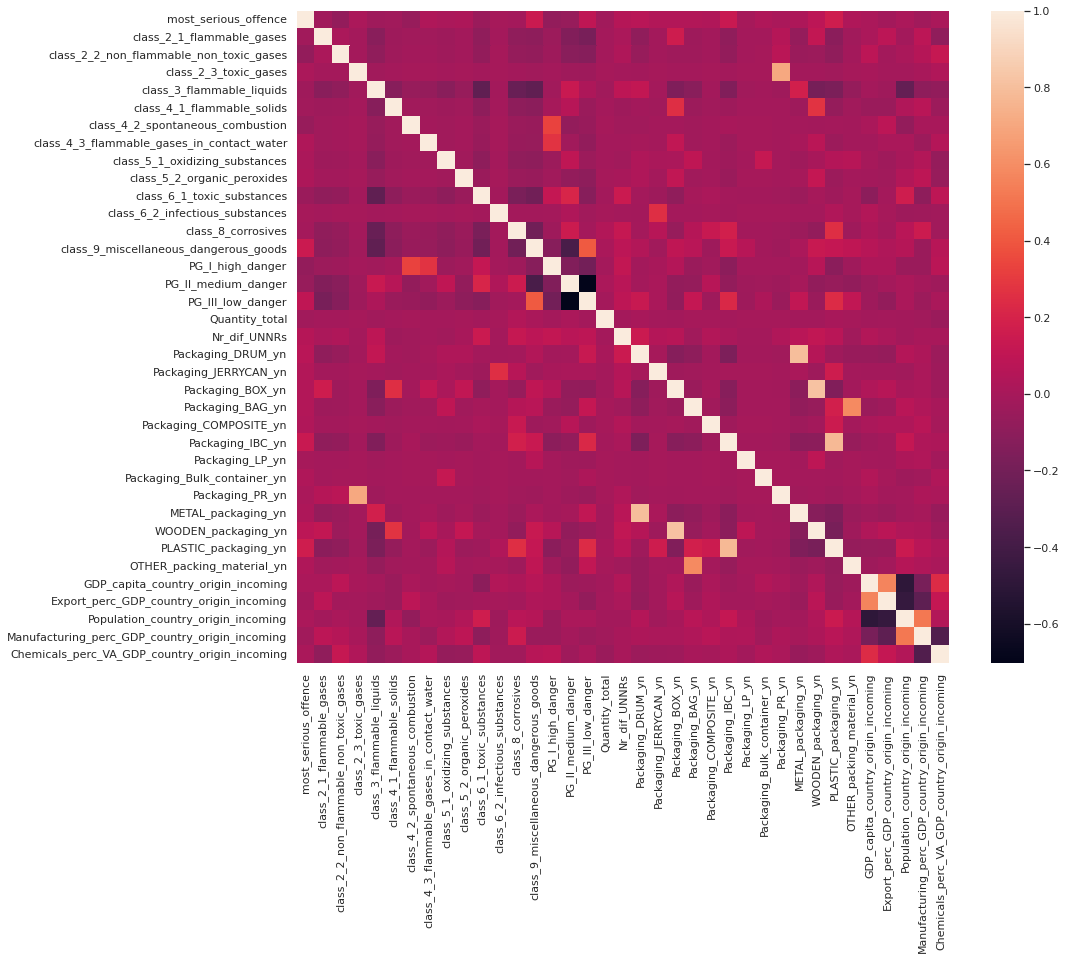

In [38]:
#checking out the correlation matrix
cor_mat= df.corr()
fig=plt.gcf()
fig.set_size_inches(15,12)
sns.heatmap(data=cor_mat, square=True, cbar=True)
plt.show()

In [36]:
cols_to_remove = ['class_1_1_explosives_mass', 'class_1_2_explosives_projection',
       'class_1_3_explosives_fire', 'class_1_4_explosives_low_risk',
       'class_1_5_explosives_mass_very_insensitive',
       'class_1_6_explosives_very_insensitive','class_7_radioactive_material','Packaging_UNPACKED_yn']
df.drop(cols_to_remove,axis=1,inplace=True)

In [39]:
df.groupby('Prisma_terminal').count()

,year,most_serious_offence,Type_cargo_transport_unit,Transportation_mode,Transportation_type,class_2_1_flammable_gases,class_2_2_non_flammable_non_toxic_gases,class_2_3_toxic_gases,class_3_flammable_liquids,class_4_1_flammable_solids,class_4_2_spontaneous_combustion,class_4_3_flammable_gases_in_contact_water,class_5_1_oxidizing_substances,class_5_2_organic_peroxides,class_6_1_toxic_substances,class_6_2_infectious_substances,class_8_corrosives,class_9_miscellaneous_dangerous_goods,PG_I_high_danger,PG_II_medium_danger,PG_III_low_danger,Quantity_total,Nr_dif_UNNRs,Packaging_DRUM_yn,Packaging_JERRYCAN_yn,Packaging_BOX_yn,Packaging_BAG_yn,Packaging_COMPOSITE_yn,Packaging_IBC_yn,Packaging_LP_yn,Packaging_Bulk_container_yn,Packaging_PR_yn,METAL_packaging_yn,WOODEN_packaging_yn,PLASTIC_packaging_yn,OTHER_packing_material_yn,Prisma_object_type,Prisma_incoming_country_origin,Prisma_incoming_country_destination,Prisma_object_type_corrected,GDP_capita_country_origin_incoming,Export_perc_GDP_country_origin_incoming,Population_country_origin_incoming,Manufacturing_perc_GDP_country_origin_incoming,Chemicals_perc_VA_GDP_country_origin_incoming,Cargo_agent,Cargo_agent_corrected
Prisma_terminal,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
APM Terminals Maasvlakte II,85,85,82,82,82,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,81,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,84,84,84,84,83,85,85
"APM Terminals Maasvlakte II, Maasvlakte-Rotterdam",48,48,48,48,48,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,46,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48,48
APM Terminals Rotterdam,175,175,170,170,170,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,175,173,173,173,173,173,175,175
"APM Terminals Rotterdam, Maasvlakte-Rotterdam",47,47,47,47,47,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,45,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47,47
"C.RO Ports Nederland B.V., Rotterdam",7,7,7,7,7,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
"Combined Cargo Terminal Moerdijk (CCT), Moerdijk",2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Combined Cargo Terminals Moerdijk (CCT),1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
ECT Delta Terminal,688,688,670,670,670,662,662,662,662,662,662,662,662,662,662,662,662,662,662,662,662,662,662,688,688,688,688,688,688,688,688,688,688,688,688,688,688,688,688,688,682,684,684,684,682,688,688
"ECT Delta Terminal, Maasvlakte-Rotterdam",312,312,312,312,312,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,311,312,312,312,312,312,312,312,312,312,312,312,312,312,312,312,312,312,310,310,310,310,310,312,312


In [41]:
df.groupby('Cargo_agent').count()

,year,most_serious_offence,Type_cargo_transport_unit,Transportation_mode,Transportation_type,class_2_1_flammable_gases,class_2_2_non_flammable_non_toxic_gases,class_2_3_toxic_gases,class_3_flammable_liquids,class_4_1_flammable_solids,class_4_2_spontaneous_combustion,class_4_3_flammable_gases_in_contact_water,class_5_1_oxidizing_substances,class_5_2_organic_peroxides,class_6_1_toxic_substances,class_6_2_infectious_substances,class_8_corrosives,class_9_miscellaneous_dangerous_goods,PG_I_high_danger,PG_II_medium_danger,PG_III_low_danger,Quantity_total,Nr_dif_UNNRs,Packaging_DRUM_yn,Packaging_JERRYCAN_yn,Packaging_BOX_yn,Packaging_BAG_yn,Packaging_COMPOSITE_yn,Packaging_IBC_yn,Packaging_LP_yn,Packaging_Bulk_container_yn,Packaging_PR_yn,METAL_packaging_yn,WOODEN_packaging_yn,PLASTIC_packaging_yn,OTHER_packing_material_yn,Prisma_object_type,Prisma_terminal,Prisma_incoming_country_origin,Prisma_incoming_country_destination,Prisma_object_type_corrected,GDP_capita_country_origin_incoming,Export_perc_GDP_country_origin_incoming,Population_country_origin_incoming,Manufacturing_perc_GDP_country_origin_incoming,Chemicals_perc_VA_GDP_country_origin_incoming,Cargo_agent_corrected
Cargo_agent,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
APL,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
BG Freight Line,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Boeckmans,54,54,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54,54
Burger Liner Agencies,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
CLDN,7,7,7,7,7,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7
CMA CGM (Holland) B.V.,185,185,181,181,181,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,178,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,185,183,183,183,183,182,185
Cornelder Scheepvaart Maatschappij,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Cross Ocean (COSCO),123,123,122,122,122,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,120,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123,123
Eimskip,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:>

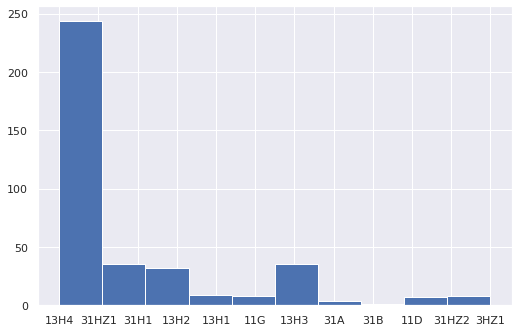

In [28]:
df['Original_code_IBCs'].hist()
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)

<AxesSubplot:>

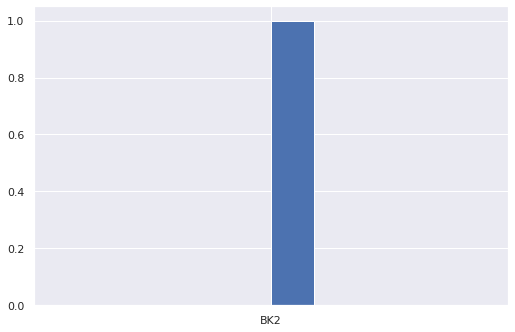

In [32]:
df['Original_code_BCs'].hist()
fig = plt.gcf()
fig.set_size_inches(8.5, 5.5)

In [4]:
undf = pd.read_csv('data/features_UNNRs.csv',index_col=False)

In [6]:
undf.drop('Unnamed: 0',axis=1,inplace=True)


,UNNR,perc_change_last_prev_12months,perc_change_last_month,perc_change_month_year_ago,total_last12months,NRJN12,perc_of_all_DG
0,4,NaN,NaN,NaN,0.0,0,0.000000
1,5,NaN,NaN,NaN,0.0,0,0.000000
2,6,NaN,NaN,NaN,61870.0,1,0.000183
3,7,NaN,NaN,NaN,0.0,0,0.000000
4,9,NaN,NaN,NaN,0.0,0,0.000000


In [3]:
import os
os.getcwd()

'/data/victorciulei/my_stuff/GS_Zee/notebooks'

In [17]:
my_group = data[['ROUTE','VZG_VOLGNUMMER','EQP_NUMMER']].groupby('EQP_NUMMER').count()

In [37]:
data.iloc[1]['ROUTE']

'CNSGH|CNSHG|CNQDG|CNTXG|CNDAG|CNDAL|CNNBO|CNQIN|CNNBG|SGSIN(11x)'

In [ ]:
data.POSTCODE

In [58]:
data.POSTCODE_VO.isnull().sum()/len(data)

0.8905758985933387

In [62]:
for col in data.columns.tolist():
    if 'POSTCODE' in col:
        mask = data[col].str.len()>4
        print(col,'fraction postcodes longer than 2:',round(mask.sum()/len(data),2))

POSTCODE_VG fraction postcodes longer than 2: 0.83
POSTCODE_OG fraction postcodes longer than 2: 0.86
POSTCODE_KG fraction postcodes longer than 2: 0.86
POSTCODE_VM fraction postcodes longer than 2: 1.0
POSTCODE_VT fraction postcodes longer than 2: 1.0
POSTCODE_VV fraction postcodes longer than 2: 0.67


AttributeError: Can only use .str accessor with string values!

In [12]:
df.columns.tolist()

['year',
 'most_serious_offence',
 'Type_cargo_transport_unit',
 'Transportation_mode',
 'Transportation_type',
 'class_1_1_explosives_mass',
 'class_1_2_explosives_projection',
 'class_1_3_explosives_fire',
 'class_1_4_explosives_low_risk',
 'class_1_5_explosives_mass_very_insensitive',
 'class_1_6_explosives_very_insensitive',
 'class_2_1_flammable_gases',
 'class_2_2_non_flammable_non_toxic_gases',
 'class_2_3_toxic_gases',
 'class_3_flammable_liquids',
 'class_4_1_flammable_solids',
 'class_4_2_spontaneous_combustion',
 'class_4_3_flammable_gases_in_contact_water',
 'class_5_1_oxidizing_substances',
 'class_5_2_organic_peroxides',
 'class_6_1_toxic_substances',
 'class_6_2_infectious_substances',
 'class_7_radioactive_material',
 'class_8_corrosives',
 'class_9_miscellaneous_dangerous_goods',
 'PG_I_high_danger',
 'PG_II_medium_danger',
 'PG_III_low_danger',
 'Quantity_total',
 'Nr_dif_UNNRs',
 'Packaging_DRUM_yn',
 'Packaging_JERRYCAN_yn',
 'Packaging_BOX_yn',
 'Packaging_BAG_yn',

In [9]:
import pandas as pd
data=pd.read_csv('../data/DMF_2019_with_DGYN_EQPNR-Copy1.csv')